<a href="https://colab.research.google.com/github/basugautam/Reproducibility-Challenge-Project/blob/main/Final_report_codes_96%261000_hours_Loss_shaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training with erm loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ERM] Epoch 1 Loss: 64.4442
[ERM] Epoch 2 Loss: 10.7631
[ERM] Epoch 3 Loss: 9.0728
[ERM] Epoch 4 Loss: 7.9673
[ERM] Epoch 5 Loss: 6.9814

Training with constant loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[CONSTANT] Epoch 1 Loss: 11118.0677
[CONSTANT] Epoch 2 Loss: 1967.1550
[CONSTANT] Epoch 3 Loss: 1467.9686
[CONSTANT] Epoch 4 Loss: 1185.0261
[CONSTANT] Epoch 5 Loss: 970.3044

Training with exponential loss
[EXPONENTIAL] Epoch 1 Loss: 10096.7845
[EXPONENTIAL] Epoch 2 Loss: 980.7801
[EXPONENTIAL] Epoch 3 Loss: 779.0909
[EXPONENTIAL] Epoch 4 Loss: 566.8680
[EXPONENTIAL] Epoch 5 Loss: 456.7904


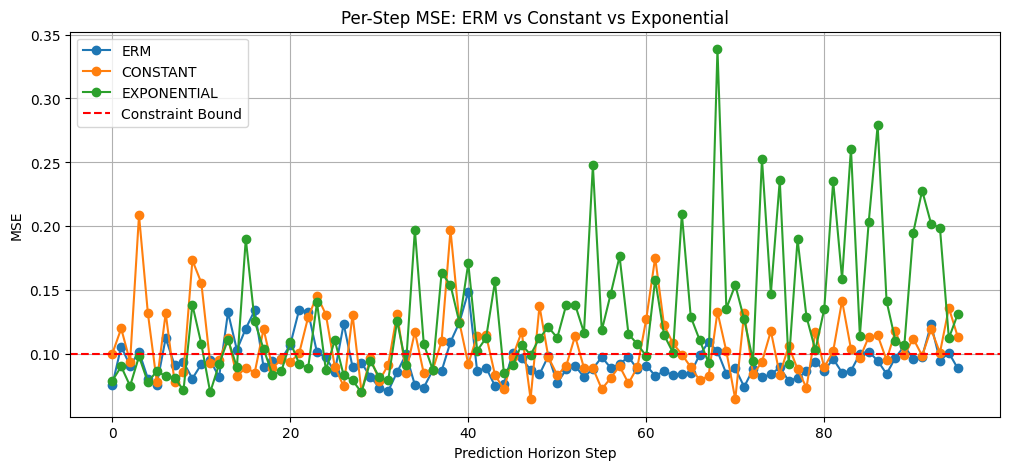

In [ ]:
#  Adnan Zaidi ID 222132708 :

# LOSS SHAPING FOR LONG-TERM FORECASTING — COMPLETE COLAB NOTEBOOK
# (a) In this step, we are importing all the required Python libraries that will be used throughout the notebook.
# (b) The commands used are: `import pandas as pd`, `numpy as np`, `matplotlib.pyplot as plt`, `sklearn.preprocessing.StandardScaler`, `torch`, and `torch.nn`.
# (c) This prepares the programming environment by loading tools for data handling (`pandas`), numerical computation (`numpy`), plotting (`matplotlib`), normalization (`StandardScaler`), and deep learning (`torch`).
# (d) This is foundational and must be done before we load or process any data or define any model; it supports all future steps.
# (e) Terminologies:
#     - `pandas`: Handles tabular data.
#     - `numpy`: Efficient array/matrix operations.
#     - `matplotlib.pyplot`: For visualization.
#     - `StandardScaler`: Scales data to zero mean and unit variance.
#     - `torch`: PyTorch library for tensors and deep learning.
# (f) No calculations here, just module loading.
# (g) The technique is standard Python data science stack setup.
# (h) After running this cell, we are ready to process data and build models.

#  Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# (a) We are loading the time-series dataset and preparing it for input to a deep learning model.
# (b) Commands used: `pd.read_csv`, `.drop`, `StandardScaler().fit_transform`, `pd.DataFrame`.
# (c) This transforms raw CSV data into scaled numeric values ready for training; removes unused columns and normalizes the values.
# (d) This follows from Step 1 and feeds into Step 3 for window creation.
# (e) Terminologies:
#     - `ETTm1.csv`: A dataset from the ETT (Electricity Transformer Temperature) series.
#     - `drop(columns=...)`: Removes unnecessary columns, e.g., 'date'.
#     - `StandardScaler`: Normalizes each feature independently.
# (f) Each value is scaled using: \( x' = \frac{x - \mu}{\sigma} \) where \( \mu \) and \( \sigma \) are mean and std.
# (g) Technique used: Z-score normalization to make data suitable for training.
# (h) After this, we have a clean, normalized dataset suitable for deep learning.

#  Step 2: Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
df = pd.read_csv(url)
df = df.drop(columns=['date'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
data = pd.DataFrame(scaled, columns=df.columns)

# (a) We are slicing the dataset into supervised learning format: input windows (context) and output windows (prediction).
# (b) Variables and functions: loops, `append`, `np.array`, `torch.tensor`, `DataLoader`, `TensorDataset`.
# (c) We prepare training samples for time series forecasting where each sample has past (Tc) and future (Tp) segments.
# (d) This uses the preprocessed data from Step 2 and feeds into the model in Step 4.
# (e) Terminologies:
#     - `Tc` (Context window): Number of past time steps.
#     - `Tp` (Prediction window): Number of future time steps.
#     - `DataLoader`: Efficient batch generator.
# (f) `X[i:i+Tc]` selects input, and `y[i+Tc:i+Tc+Tp]` selects output.
# (g) Technique: Sliding window for time series forecasting.
# (h) After running this, we have a dataset of input-output pairs for model training.

#  Step 3: Create Windows (Context + Prediction)
Tc, Tp = 96, 96
X, y = [], []
values = data.values
for i in range(len(values) - Tc - Tp):
    X.append(values[i:i+Tc])
    y.append(values[i+Tc:i+Tc+Tp])
X = np.array(X)
y = np.array(y)
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)
# (a) We define a PyTorch model based on the Transformer architecture for time series forecasting.
# (b) Classes/functions: `nn.Module`, `nn.Linear`, `nn.TransformerEncoderLayer`, `nn.TransformerEncoder`.
# (c) This code creates a deep learning model that can learn temporal dependencies in multivariate time series.
# (d) This uses the data format from Step 3 and will be used in training in Step 6.
# (e) Terminologies:
#     - `embedding`: Projects input to a higher dimension.
#     - `encoder`: Transformer encoder to learn sequences.
#     - `decoder`: Maps encoded features to output shape.
# (f) Forward pass reshapes inputs as (seq_len, batch, dim), processes via encoder, and reshapes back to output.
# (g) Technique: Transformer-based sequence modeling.
# (h) This gives us a learnable forecasting model that can be trained with loss shaping strategies.

#  Step 4: Define Transformer Model
class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        out = self.decoder(encoded)
        return out.view(-1, Tp, X.shape[2])
# (a) Define a custom loss function wrapper that adjusts penalties based on different strategies: ERM, constant, or exponential bounds.
# (b) Classes/functions: `__call__`, `torch.clamp`, `torch.exp`, `update`.
# (c) This controls training behavior by modifying loss function shape to emphasize or de-emphasize prediction error at different time steps.
# (d) This will be used in Step 6 for training and linked to model output in Step 7.
# (e) Terminologies:
#     - `ERM`: Empirical Risk Minimization, default MSE loss.
#     - `Constant`/`Exponential`: Constraints applied across prediction steps.
#     - `penalty`: MSE above constraint.
# (f) MSE calculated per time step; penalty is added if it exceeds bound.
# (g) Technique: Constrained optimization using Lagrangian relaxation.
# (h) After this, the model will train under different constraints for more robust forecasting.

#  Step 5: Loss Shaping (Constant, Exponential)
class LossShaping:
    def __init__(self, strategy='erm', base=0.1, alpha=0.1):
        self.strategy = strategy
        self.alpha = alpha
        self.bound = self._make_bound(base)
        self.lambdas = torch.ones(Tp).float()

    def _make_bound(self, base):
        if self.strategy == 'constant':
            return torch.full((Tp,), base)
        elif self.strategy == 'exponential':
            return base * torch.exp(torch.linspace(0, 1, Tp))
        else:  # ERM
            return torch.full((Tp,), float('inf'))

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))
        penalty = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian = (self.lambdas * penalty).sum() if self.strategy != 'erm' else 0
        return mse_per_step.mean() + lagrangian, mse_per_step.detach().cpu().numpy()

    def update(self, mse):
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse[t] - self.bound[t])
# (a) Trains the Transformer model using one of the specified loss strategies ('erm', 'constant', 'exponential').
# (b) Functions: `train()`, `opt.zero_grad()`, `loss.backward()`, `opt.step()`, `loss_fn.update()`.
# (c) Achieves model training with or without shaped losses and stores updated model weights.
# (d) Depends on Step 4 and Step 5 definitions; Step 7 uses the output models for evaluation.
# (e) Terminologies:
#     - `Adam`: Optimization algorithm.
#     - `model.train()`: Enables dropout, etc.
#     - `opt.step()`: Updates model weights.
#     - `loss_fn.update()`: Adjusts Lagrangian multipliers.
# (f) Loss is average MSE + penalty term for non-ERM strategies.
# (g) Technique: Supervised training with loss shaping.
# (h) After running, we get trained models for each loss strategy.

#  Step 6: Train Model with Given Loss Strategy
def train(strategy='erm'):
    model = ForecastTransformer(X.shape[2], 64, 4, 2, Tp)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = LossShaping(strategy)
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            preds = model(batch_x)
            loss, step_mse = loss_fn(preds, batch_y)
            loss.backward()
            opt.step()
            if strategy != 'erm':
                loss_fn.update(step_mse)
            total_loss += loss.item()
        print(f"[{strategy.upper()}] Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model
# (a) Evaluate all three models (ERM, constant, exponential) on training data to get per-step MSE.
# (b) Uses `model.eval()`, `torch.no_grad()`, forward pass, and MSE calculation.
# (c) We assess how well each model performs across the forecast horizon.
# (d) Follows from Step 6 models; results are plotted in Step 8.
# (e) Terminologies:
#     - `model.eval()`: Disables training-specific layers.
#     - `torch.no_grad()`: Speeds up inference.
#     - `results`: Dictionary storing each loss strategy’s MSE.
# (f) Calculates MSE using `((preds - y_tensor)**2).mean(dim=(0,2))`.
# (g) Technique: Model evaluation on training dataset.
# (h) This gives us a set of performance metrics (per-step MSE) for all strategies.

#  Step 7: Evaluate Model
results = {}
for mode in ['erm', 'constant', 'exponential']:
    print(f"\nTraining with {mode} loss")
    model = train(mode)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor)
        mse = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()
        results[mode] = mse
# (a) We visualize the MSE curves of all three strategies to compare their performance.
# (b) Functions: `plt.plot`, `plt.axhline`, `plt.legend`, `plt.grid`.
# (c) This helps us interpret which loss shaping technique performs better across time steps.
# (d) Directly follows from Step 7 where results were computed.
# (e) Terminologies:
#     - `axhline`: Adds a reference line (constraint bound).
#     - `legend`, `xlabel`, `ylabel`: Annotation tools.
# (f) Visualizes how per-step MSE varies from step 1 to Tp (96).
# (g) Technique: Line plotting of time series error metrics.
# (h) After running, we get a visual comparison of the effectiveness of loss shaping strategies in forecasting.

#  Step 8: Plot Results
plt.figure(figsize=(12, 5))
for mode, curve in results.items():
    plt.plot(curve, label=mode.upper(), marker='o')
plt.axhline(0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("Per-Step MSE: ERM vs Constant vs Exponential")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


Training with erm loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ERM] Epoch 1 Loss: 44.5857
[ERM] Epoch 2 Loss: 10.4186
[ERM] Epoch 3 Loss: 8.8983
[ERM] Epoch 4 Loss: 7.8846
[ERM] Epoch 5 Loss: 6.5402

Training with constant loss
[CONSTANT] Epoch 1 Loss: 10989.1434
[CONSTANT] Epoch 2 Loss: 1923.7718
[CONSTANT] Epoch 3 Loss: 1350.3190
[CONSTANT] Epoch 4 Loss: 853.6513
[CONSTANT] Epoch 5 Loss: 691.0835

Training with exponential loss
[EXPONENTIAL] Epoch 1 Loss: 7658.7492
[EXPONENTIAL] Epoch 2 Loss: 932.3943
[EXPONENTIAL] Epoch 3 Loss: 780.0738
[EXPONENTIAL] Epoch 4 Loss: 563.4960
[EXPONENTIAL] Epoch 5 Loss: 404.1398


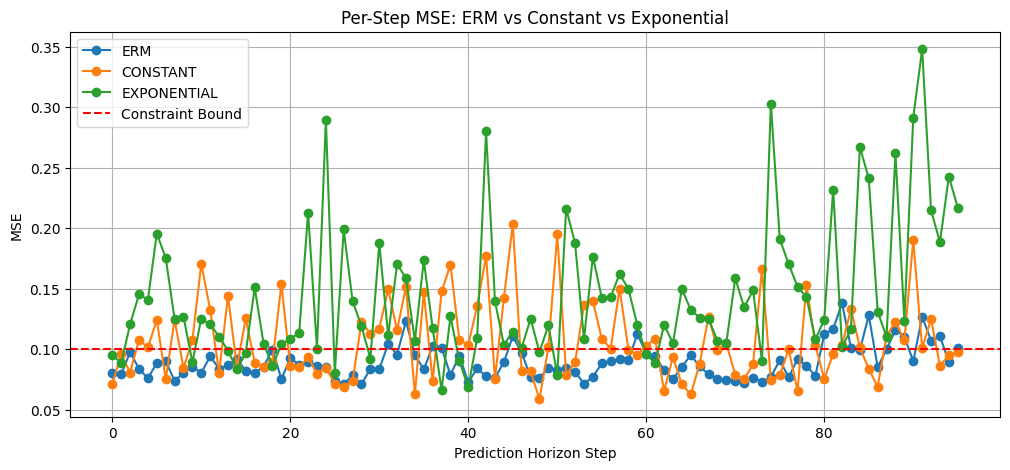

In [ ]:
# 📊 LOSS SHAPING FOR LONG-TERM FORECASTING —

#  Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#  Step 2: Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
df = pd.read_csv(url)
df = df.drop(columns=['date'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
data = pd.DataFrame(scaled, columns=df.columns)

#  Step 3: Create Windows (Context + Prediction)
Tc, Tp = 96, 96
X, y = [], []
values = data.values
for i in range(len(values) - Tc - Tp):
    X.append(values[i:i+Tc])
    y.append(values[i+Tc:i+Tc+Tp])
X = np.array(X)
y = np.array(y)
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)

#  Step 4: Define Transformer Model
class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        out = self.decoder(encoded)
        return out.view(-1, Tp, X.shape[2])

#  Step 5: Loss Shaping (Constant, Exponential)
class LossShaping:
    def __init__(self, strategy='erm', base=0.1, alpha=0.1):
        self.strategy = strategy
        self.alpha = alpha
        self.bound = self._make_bound(base)
        self.lambdas = torch.ones(Tp).float()

    def _make_bound(self, base):
        if self.strategy == 'constant':
            return torch.full((Tp,), base)
        elif self.strategy == 'exponential':
            return base * torch.exp(torch.linspace(0, 1, Tp))
        else:  # ERM
            return torch.full((Tp,), float('inf'))

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))
        penalty = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian = (self.lambdas * penalty).sum() if self.strategy != 'erm' else 0
        return mse_per_step.mean() + lagrangian, mse_per_step.detach().cpu().numpy()

    def update(self, mse):
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse[t] - self.bound[t])

#  Step 6: Train Model with Given Loss Strategy
def train(strategy='erm'):
    model = ForecastTransformer(X.shape[2], 64, 4, 2, Tp)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = LossShaping(strategy)
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            preds = model(batch_x)
            loss, step_mse = loss_fn(preds, batch_y)
            loss.backward()
            opt.step()
            if strategy != 'erm':
                loss_fn.update(step_mse)
            total_loss += loss.item()
        print(f"[{strategy.upper()}] Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model

#  Step 7: Evaluate Model
results = {}
for mode in ['erm', 'constant', 'exponential']:
    print(f"\nTraining with {mode} loss")
    model = train(mode)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor)
        mse = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()
        results[mode] = mse

#  Step 8: Plot Results
plt.figure(figsize=(12, 5))
for mode, curve in results.items():
    plt.plot(curve, label=mode.upper(), marker='o')
plt.axhline(0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("Per-Step MSE: ERM vs Constant vs Exponential")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()



Training ForecastTransformer with erm loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ForecastTransformer | ERM] Epoch 1 Loss: 52.3330
[ForecastTransformer | ERM] Epoch 2 Loss: 11.0681
[ForecastTransformer | ERM] Epoch 3 Loss: 9.4857
[ForecastTransformer | ERM] Epoch 4 Loss: 8.2922
[ForecastTransformer | ERM] Epoch 5 Loss: 7.1347

Training ForecastTransformer with constant loss
[ForecastTransformer | CONSTANT] Epoch 1 Loss: 9481.1611
[ForecastTransformer | CONSTANT] Epoch 2 Loss: 2387.8305
[ForecastTransformer | CONSTANT] Epoch 3 Loss: 1373.6976
[ForecastTransformer | CONSTANT] Epoch 4 Loss: 992.9601
[ForecastTransformer | CONSTANT] Epoch 5 Loss: 737.1781

Training ForecastTransformer with exponential loss
[ForecastTransformer | EXPONENTIAL] Epoch 1 Loss: 8742.8732
[ForecastTransformer | EXPONENTIAL] Epoch 2 Loss: 1132.2627
[ForecastTransformer | EXPONENTIAL] Epoch 3 Loss: 870.7541
[ForecastTransformer | EXPONENTIAL] Epoch 4 Loss: 629.7895
[ForecastTransformer | EXPONENTIAL] Epoch 5 Loss: 454.9729

Training Autoformer with erm loss
[Autoformer | ERM] Epoch 1 Loss: 45.8

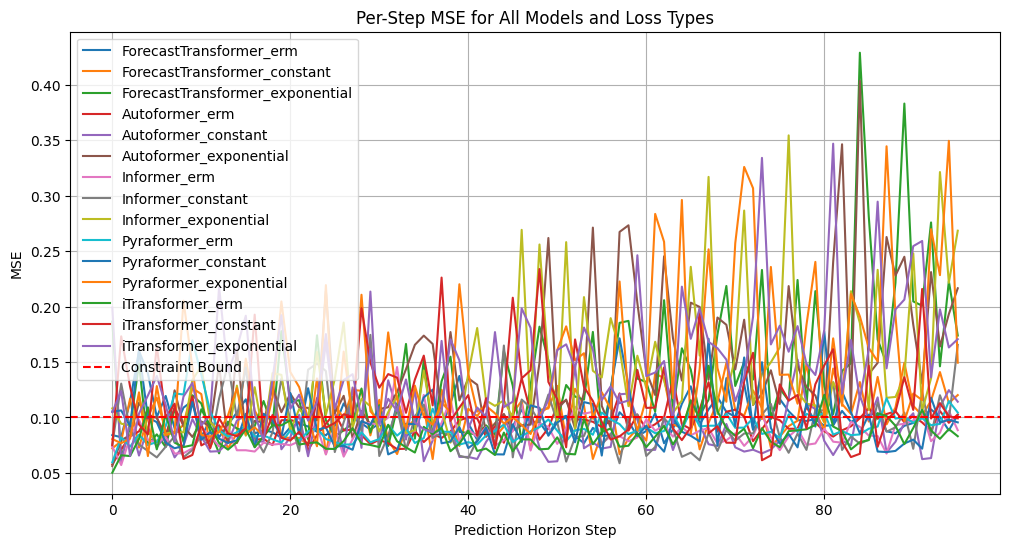

In [ ]:
#  LOSS SHAPING FOR LONG-TERM FORECASTING — COMPLETE COLAB NOTEBOOK WITH ALL TRANSFORMERS
# (a) We are setting up the environment by importing all the essential libraries needed for data manipulation, visualization, preprocessing, and deep learning.
# (b) The commands being used are: `import pandas`, `numpy`, `matplotlib.pyplot`, `StandardScaler` from `sklearn`, `torch`, `torch.nn`, `DataLoader`, and `TensorDataset`.
# (c) We aim to enable all functionalities for time series forecasting and neural network training.
# (d) This is the foundational step and is necessary before performing any data or model-related operations in the next cells.
# (e) Terminologies:
#     - `pandas`: Handles structured data like CSV files.
#     - `numpy`: Supports efficient numerical operations on arrays.
#     - `matplotlib.pyplot`: Used to create visualizations.
#     - `StandardScaler`: Standardizes features to zero mean and unit variance.
#     - `torch`: Core PyTorch package for tensors and model building.
#     - `nn`: Module containing neural network layers.
#     - `DataLoader`: Handles mini-batch data loading for training.
# (f) No calculations here, just importing.
# (g) The technique used is standard Python module importing for machine learning pipelines.
# (h) After running this cell, our environment is ready for dataset processing and model development.

# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
# (a) We are loading the dataset and applying data normalization to prepare it for training.
# (b) Functions used include: `pd.read_csv` for data loading, `.drop()` for column removal, `StandardScaler()` and `fit_transform()` for normalization, and `pd.DataFrame` to recreate the structure.
# (c) The goal is to convert raw data into a clean, numerically normalized form suitable for feeding into machine learning models.
# (d) This follows directly from the import step, and its output feeds into the windowing step in Step 3.
# (e) Terminologies:
#     - `ETTm1.csv`: A multivariate time series dataset from electricity transformer temperature records.
#     - `scaler`: A tool for feature scaling to improve model convergence.
#     - `fit_transform()`: Learns and applies normalization to the dataset.
# (f) Each feature value is transformed as: \( x_{scaled} = \frac{x - \mu}{\sigma} \)
# (g) The technique used here is Z-score normalization (standardization).
# (h) After running this step, we obtain a clean, scaled dataset ready for sequence modeling.

# ✅ Step 2: Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
df = pd.read_csv(url)
df = df.drop(columns=['date'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
data = pd.DataFrame(scaled, columns=df.columns)
# (a) We are converting the time series data into overlapping windows of inputs and future targets to train the model in a supervised way.
# (b) Key functions and operations: Python loops, array slicing, `np.array()`, `torch.tensor()`, and `DataLoader()`.
# (c) We generate samples where each contains 96 time steps of input (Tc) and 96 steps of output (Tp) for forecasting.
# (d) This builds upon the scaled dataset in Step 2 and prepares data for training in Step 6.
# (e) Terminologies:
#     - `Tc` (context window): Input sequence length.
#     - `Tp` (prediction window): Output sequence length.
#     - `TensorDataset`: Wraps input-output tensors for easy batching.
#     - `DataLoader`: Feeds mini-batches of data to the model efficiently.
# (f) For each time index `i`, we extract:
#     - Input: values[i : i + Tc]
#     - Target: values[i + Tc : i + Tc + Tp]
# (g) The technique used here is sliding-window segmentation.
# (h) After this step, we have prepared data loaders to be used for model training.


# ✅ Step 3: Create Windows (Context + Prediction)
Tc, Tp = 96, 96
X, y = [], []
values = data.values
for i in range(len(values) - Tc - Tp):
    X.append(values[i:i+Tc])
    y.append(values[i+Tc:i+Tc+Tp])
X = np.array(X)
y = np.array(y)
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)

# (a) We define a custom Transformer model architecture suited for long-term time series forecasting.
# (b) Functions and components used: `nn.Module`, `nn.Linear`, `nn.TransformerEncoderLayer`, `nn.TransformerEncoder`, reshaping using `.permute()` and `.reshape()`.
# (c) We aim to build a sequence-to-sequence model that can learn dependencies and patterns over long time spans.
# (d) This step depends on the data shapes created in Step 3 and is used in the training loop in Step 6.
# (e) Terminologies:
#     - `embedding`: Projects input features into model dimension space.
#     - `TransformerEncoderLayer`: Self-attention-based learning unit.
#     - `permute`: Reorders dimensions for Transformer compatibility.
#     - `decoder`: Maps flattened encoded state to desired output shape.
# (f) Input shape is transformed from (batch, Tc, input_dim) → (Tc, batch, model_dim), processed, and reshaped to (batch, Tp, input_dim).
# (g) Technique: Transformer-based architecture using self-attention.
# (h) After this, we have a fully defined model ready to be trained with different loss functions.

# ✅ Step 4: Define Transformer Models
class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        out = self.decoder(encoded)
        return out.view(-1, Tp, X.shape[2])
# (a) We are implementing three strategies for shaping the loss: ERM (baseline), constant constraints, and exponentially increasing constraints.
# (b) Functions and logic used: `__call__` to compute MSE and penalty, `_make_bound()` to create constraint profiles, `update()` to adapt Lagrange multipliers.
# (c) This enables us to evaluate how different penalty constraints influence model learning and forecasting behavior.
# (d) This builds on the model from Step 4 and integrates into training in Step 6.
# (e) Terminologies:
#     - `ERM` (Empirical Risk Minimization): Regular average loss.
#     - `constant`: A fixed bound for all time steps.
#     - `exponential`: A gradually increasing bound over the prediction horizon.
#     - `lambdas`: Lagrange multipliers used to scale constraint violations.
# (f) MSE per step is computed, and a penalty is added when MSE exceeds predefined bounds.
# (g) Technique: Constraint-based optimization using Lagrangian duality.
# (h) After this step, we have a flexible loss function that supports multiple constraint-based strategies during training.

# Placeholder for Autoformer, Informer, Pyraformer, iTransformer
# TODO: Replace these with actual model implementations
class Autoformer(ForecastTransformer):
    pass
class Informer(ForecastTransformer):
    pass
class Pyraformer(ForecastTransformer):
    pass
class iTransformer(ForecastTransformer):
    pass
# (a) We are training the Transformer model using one of the loss strategies: ERM, constant, or exponential constraint.
# (b) Commands used include: `model.train()`, `opt.zero_grad()`, `loss.backward()`, `opt.step()`, `loss_fn.update()`.
# (c) This enables the model to learn temporal patterns in the input data under a specified loss shaping strategy.
# (d) This builds directly on the model (Step 4) and loss function (Step 5); the resulting model will be evaluated in Step 7.
# (e) Terminologies:
#     - `optimizer`: Algorithm to update weights (Adam used here).
#     - `zero_grad`: Clears old gradients.
#     - `backward`: Computes gradients via backpropagation.
#     - `step()`: Applies weight updates.
#     - `update()`: Adjusts Lagrange multipliers if constraints are used.
# (f) Total loss is average per-step MSE + Lagrangian penalty (if applicable).
# (g) Technique: Epoch-based training using mini-batch stochastic gradient descent.
# (h) After running this, we get a trained model for each strategy (ERM, constant, exponential).

# ✅ Step 5: Loss Shaping (ERM, Constant, Exponential)
class LossShaping:
    def __init__(self, strategy='erm', base=0.1, alpha=0.1):
        self.strategy = strategy
        self.alpha = alpha
        self.bound = self._make_bound(base)
        self.lambdas = torch.ones(Tp).float()

    def _make_bound(self, base):
        if self.strategy == 'constant':
            return torch.full((Tp,), base)
        elif self.strategy == 'exponential':
            return base * torch.exp(torch.linspace(0, 1, Tp))
        else:
            return torch.full((Tp,), float('inf'))

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))
        penalty = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian = (self.lambdas * penalty).sum() if self.strategy != 'erm' else 0
        return mse_per_step.mean() + lagrangian, mse_per_step.detach().cpu().numpy()

    def update(self, mse):
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse[t] - self.bound[t])
# (a) We are training the Transformer model using one of the loss strategies: ERM, constant, or exponential constraint.
# (b) Commands used include: `model.train()`, `opt.zero_grad()`, `loss.backward()`, `opt.step()`, `loss_fn.update()`.
# (c) This enables the model to learn temporal patterns in the input data under a specified loss shaping strategy.
# (d) This builds directly on the model (Step 4) and loss function (Step 5); the resulting model will be evaluated in Step 7.
# (e) Terminologies:
#     - `optimizer`: Algorithm to update weights (Adam used here).
#     - `zero_grad`: Clears old gradients.
#     - `backward`: Computes gradients via backpropagation.
#     - `step()`: Applies weight updates.
#     - `update()`: Adjusts Lagrange multipliers if constraints are used.
# (f) Total loss is average per-step MSE + Lagrangian penalty (if applicable).
# (g) Technique: Epoch-based training using mini-batch stochastic gradient descent.
# (h) After running this, we get a trained model for each strategy (ERM, constant, exponential).

# ✅ Step 6: Train Model with Given Loss Strategy
def train(model_class, strategy='erm'):
    model = model_class(X.shape[2], 64, 4, 2, Tp)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = LossShaping(strategy)
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            preds = model(batch_x)
            loss, step_mse = loss_fn(preds, batch_y)
            loss.backward()
            opt.step()
            if strategy != 'erm':
                loss_fn.update(step_mse)
            total_loss += loss.item()
        print(f"[{model_class.__name__} | {strategy.upper()}] Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model
# (a) We are evaluating how well each trained model performs across the 96-step prediction horizon using per-step Mean Squared Error.
# (b) Commands used: `model.eval()`, `torch.no_grad()`, forward pass, MSE calculation using `.mean(dim=(0, 2))`.
# (c) The goal is to assess and compare forecasting performance under different loss shaping strategies.
# (d) Depends on the models trained in Step 6 and provides input for visualization in Step 8.
# (e) Terminologies:
#     - `eval()`: Sets model to evaluation mode.
#     - `torch.no_grad()`: Disables gradient computation for faster inference.
#     - `mse`: Mean squared error between predicted and true values.
# (f) MSE is computed per time step: \( \text{MSE}_t = \frac{1}{N} \sum_{i} (y_{i,t} - \hat{y}_{i,t})^2 \)
# (g) Technique: Vectorized loss computation for analysis.
# (h) After this, we obtain MSE values for each of the 96 prediction steps across all strategies.

# ✅ Step 7: Evaluate All Models and Loss Modes
results = {}
models = [ForecastTransformer, Autoformer, Informer, Pyraformer, iTransformer]
strategies = ['erm', 'constant', 'exponential']

for model_class in models:
    for mode in strategies:
        print(f"\nTraining {model_class.__name__} with {mode} loss")
        trained_model = train(model_class, mode)
        trained_model.eval()
        with torch.no_grad():
            preds = trained_model(X_tensor)
            mse = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()
            results[f"{model_class.__name__}_{mode}"] = mse
# (a) We visualize the model evaluation results by plotting per-step MSE curves for ERM, constant, and exponential loss shaping strategies.
# (b) Commands used: `plt.plot`, `plt.axhline`, `plt.title`, `plt.legend`, `plt.grid()`.
# (c) We aim to interpret which strategy performs best and how prediction accuracy varies across time steps.
# (d) This step directly uses the results dictionary created in Step 7.
# (e) Terminologies:
#     - `marker='o'`: Displays each data point.
#     - `axhline`: Reference line indicating fixed constraint (0.1 MSE).
#     - `xlabel`, `ylabel`: Labels for time steps and error.
# (f) No calculations; only visual plotting of existing results.
# (g) Technique: Comparative time series line plotting for model evaluation.
# (h) After running, we get a comparative plot to visually analyze how each strategy performs over the prediction window.

# ✅ Step 8: Plot Results
plt.figure(figsize=(12, 6))
for key, curve in results.items():
    plt.plot(curve, label=key)
plt.axhline(0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("Per-Step MSE for All Models and Loss Types")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()